In [10]:
import os
import numpy as np
import shutil #high level file operations
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Using TensorFlow backend.


##### We download data from https://www.kaggle.com/c/dogs-vs-cats/data and put the training data into 'images' subdirectory, to be divided later into train, validation and test data!

In [2]:
BASE_PATH = '/Users/gursharan/Desktop/dogs-vs-cats'
total_images_per_class = 12500
RAW_IMAGE_PATH = os.path.join( BASE_PATH, 'images')

In [3]:
train_path = os.path.join( BASE_PATH, 'train' )
test_path = os.path.join( BASE_PATH, 'test' )
validation_path = os.path.join( BASE_PATH, 'validation' )
all_paths = [ train_path, test_path, validation_path ]

In [4]:
for path in all_paths:
    cat_sub_dir = os.path.join( path, 'cats')
    dogs_sub_dir = os.path.join( path, 'dogs')
    if not os.path.exists(path):
        os.mkdir(path)
    if not os.path.exists(cat_sub_dir):
        os.mkdir(cat_sub_dir)
    if not os.path.exists(dogs_sub_dir):
        os.mkdir(dogs_sub_dir)

In [5]:
def arrange(src_dir, tgt_dir, data_range):
    #ideally we should use permuted set of images 
    #than choosing same range for both dog and cat image
    cat_file_names = [ 'cat.{}.jpg'.format(index) for index in data_range ]
    dog_file_names = [ 'dog.{}.jpg'.format(index) for index in data_range ]
    for file_name in cat_file_names:
        src = os.path.join(src_dir, file_name)
        tgt = os.path.join(os.path.join(tgt_dir, 'cats'), file_name)
        shutil.copyfile(src,tgt)
    for file_name in dog_file_names:
        src = os.path.join(src_dir, file_name)
        tgt = os.path.join(os.path.join(tgt_dir, 'dogs'), file_name)
        shutil.copyfile(src,tgt)

In [6]:
# training_data
training_images = (6*total_images_per_class)//10
data_range = range(0, training_images)
arrange( RAW_IMAGE_PATH, train_path, data_range)

# validation_data
validation_images = training_images//3
data_range = range(training_images, training_images + validation_images )
arrange( RAW_IMAGE_PATH, validation_path, data_range)

# testing_data
data_range = range(training_images + validation_images, total_images_per_class)
arrange( RAW_IMAGE_PATH, test_path, data_range)

In [8]:
print('Total training cat images :', len(os.listdir(os.path.join(train_path, 'cats'))))
print('Total training dog images :', len(os.listdir(os.path.join(train_path, 'dogs'))))
print('Total validation cat images :', len(os.listdir(os.path.join(validation_path, 'cats'))))
print('Total validation dog images :', len(os.listdir(os.path.join(validation_path, 'dogs'))))
print('Total testing cat images :', len(os.listdir(os.path.join(test_path, 'cats'))))
print('Total testing dog images :', len(os.listdir(os.path.join(test_path, 'dogs'))))

Total training cat images : 7500
Total training dog images : 7500
Total validation cat images : 2500
Total validation dog images : 2500
Total testing cat images : 2500
Total testing dog images : 2500


In [11]:
# initial model
# generally patterns here is to have stacks of conv2D and maxpooling2D in the network. We want network to end
# with layer with one neuron. Input shape is (150,150), this is shape that we will pass to ImageDataGenerator as well
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
model.summary()
#note how length,width of image keeps on decreasing while depth keeps on increasing as we go deeper in the network

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [15]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [17]:
#scale them by 1/255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path,target_size=(150, 150),
                           batch_size=50,class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(validation_path,target_size=(150, 150),
                           batch_size=50,class_mode='binary')

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [18]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=300,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=100)

Epoch 1/30
300/300 [==============================] - 240s 800ms/step - loss: 0.6841 - acc: 0.5901 - val_loss: 0.6631 - val_acc: 0.6526
Epoch 2/30
300/300 [==============================] - 232s 772ms/step - loss: 0.5476 - acc: 0.7263 - val_loss: 0.6907 - val_acc: 0.6942
Epoch 3/30
300/300 [==============================] - 245s 817ms/step - loss: 0.4618 - acc: 0.7827 - val_loss: 0.3395 - val_acc: 0.7832
Epoch 4/30
300/300 [==============================] - 255s 849ms/step - loss: 0.3911 - acc: 0.8257 - val_loss: 0.4170 - val_acc: 0.8242
Epoch 5/30
300/300 [==============================] - 252s 841ms/step - loss: 0.3347 - acc: 0.8549 - val_loss: 0.3320 - val_acc: 0.8040
Epoch 6/30
300/300 [==============================] - 255s 848ms/step - loss: 0.2795 - acc: 0.8819 - val_loss: 0.3575 - val_acc: 0.8482
Epoch 7/30
300/300 [==============================] - 252s 839ms/step - loss: 0.2321 - acc: 0.9033 - val_loss: 0.3353 - val_acc: 0.8564
Epoch 8/30
300/300 [============================

In [19]:
model.save('cats_and_dogs_small_1.h5') #save the model after training- interesting!

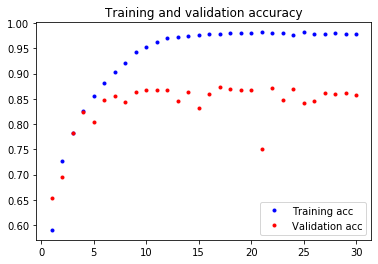

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b.', label='Training acc')
plt.plot(epochs, val_acc, 'r.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

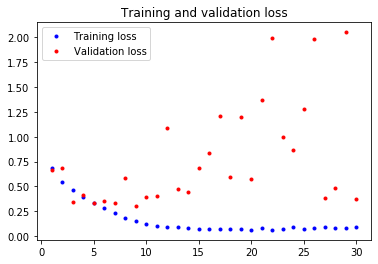

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b.', label='Training loss')
plt.plot(epochs, val_loss, 'r.', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### We see as number of epochs increase, gap between training and validation accuracy increases! This is sign of overfitting! To overcome this, we will try couple of tricks - data augmentation and dropouts!

In [29]:
# Using data augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path,target_size=(150, 150),
                           batch_size=50,class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(validation_path,target_size=(150, 150),
                           batch_size=50,class_mode='binary')

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [25]:
# initial model - but with added dropout layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [26]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [30]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=300,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=100)

Epoch 1/30
300/300 [==============================] - 259s 862ms/step - loss: 0.6858 - acc: 0.5471 - val_loss: 0.6980 - val_acc: 0.6000
Epoch 2/30
300/300 [==============================] - 246s 821ms/step - loss: 0.6630 - acc: 0.5947 - val_loss: 0.6675 - val_acc: 0.6276
Epoch 3/30
300/300 [==============================] - 245s 816ms/step - loss: 0.6434 - acc: 0.6287 - val_loss: 0.6600 - val_acc: 0.6674
Epoch 4/30
300/300 [==============================] - 246s 821ms/step - loss: 0.6213 - acc: 0.6562 - val_loss: 0.5986 - val_acc: 0.6988
Epoch 5/30
300/300 [==============================] - 245s 817ms/step - loss: 0.5974 - acc: 0.6832 - val_loss: 0.6682 - val_acc: 0.6992
Epoch 6/30
300/300 [==============================] - 244s 815ms/step - loss: 0.5831 - acc: 0.6979 - val_loss: 0.4946 - val_acc: 0.7344
Epoch 7/30
300/300 [==============================] - 245s 816ms/step - loss: 0.5801 - acc: 0.6941 - val_loss: 0.3942 - val_acc: 0.7216
Epoch 8/30
300/300 [============================

In [31]:
model.save('cats_and_dogs_small_2.h5')

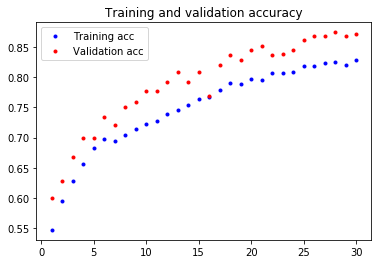

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b.', label='Training acc')
plt.plot(epochs, val_acc, 'r.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

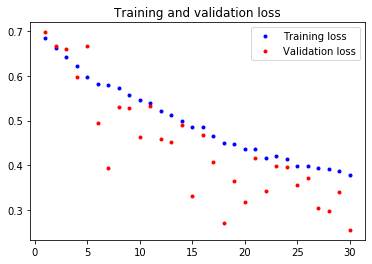

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b.', label='Training loss')
plt.plot(epochs, val_loss, 'r.', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### This looks much much better than what we had before!! Note we do not see overfitting for this run! - but we have sacrificed the training accuracy we saw without usage of regularization. We do see improved validation accuracy too.

### Using pretrained network!

In [34]:
# 1. feature extraction
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

In [35]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

##### There is no dropout layer - the concept of dropout was introduced after VGG16 was published

In [52]:
# A. Extracting features using convolution base and then using that in separate dense connected classifier
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 1500
def extract_features_from_conv_base( directory, samples ):
    features = np.zeros(shape=(samples, 4, 4, 512 )) #shape of top-most layer
    labels = np.zeros(shape=(samples))
    generator = datagen.flow_from_directory( directory, 
                        target_size=(150,150),
                        batch_size = batch_size, class_mode='binary' )
    i = 0
    for inputs_batch, label_batch in generator:
        features_batch = conv_base.predict( inputs_batch )
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = label_batch
        i += 1
        if i*batch_size >= samples:
            break
    return features, labels

In [53]:
train_features, train_labels = extract_features_from_conv_base(train_path, 15000)
validation_features, validation_labels = extract_features_from_conv_base(validation_path, 5000)
test_features, test_labels = extract_features_from_conv_base(test_path, 5000)

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [54]:
#flatten
train_features = np.reshape(train_features, (15000,4*4*512))
validation_features = np.reshape(validation_features, (5000,4*4*512))
test_features = np.reshape(test_features, (5000,4*4*512))

In [56]:
model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim=4* 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adamax',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(train_features, train_labels,epochs=30,batch_size=50,validation_data=(validation_features, validation_labels))

Train on 15000 samples, validate on 5000 samples
Epoch 1/30
15000/15000 [==============================] - 10s 636us/step - loss: 0.3572 - acc: 0.8570 - val_loss: 0.2422 - val_acc: 0.8952
Epoch 2/30
15000/15000 [==============================] - 9s 628us/step - loss: 0.2326 - acc: 0.9030 - val_loss: 0.2183 - val_acc: 0.9124
Epoch 3/30
15000/15000 [==============================] - 9s 615us/step - loss: 0.2156 - acc: 0.9119 - val_loss: 0.2227 - val_acc: 0.9050
Epoch 4/30
15000/15000 [==============================] - 10s 643us/step - loss: 0.1980 - acc: 0.9173 - val_loss: 0.2090 - val_acc: 0.9134
Epoch 5/30
15000/15000 [==============================] - 10s 640us/step - loss: 0.1890 - acc: 0.9237 - val_loss: 0.2326 - val_acc: 0.9052
Epoch 6/30
15000/15000 [==============================] - 9s 623us/step - loss: 0.1729 - acc: 0.9295 - val_loss: 0.2104 - val_acc: 0.9140
Epoch 7/30
15000/15000 [==============================] - 9s 622us/step - loss: 0.1648 - acc: 0.9336 - val_loss: 0.2035 

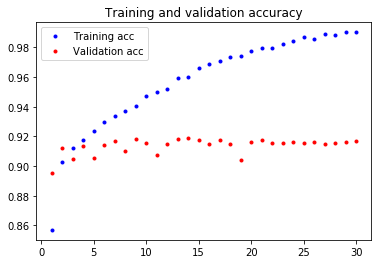

In [57]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b.', label='Training acc')
plt.plot(epochs, val_acc, 'r.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

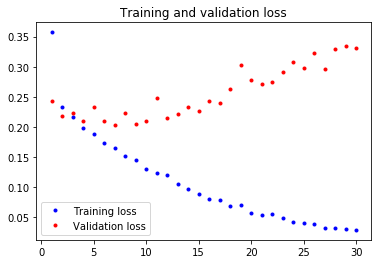

In [58]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b.', label='Training loss')
plt.plot(epochs, val_loss, 'r.', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### We see better validation accuracy with it - however we can still see overfitting happenning beside using dropouts. We should try out data augmentation too! The efficiency we achieved by running images through conv_base only once in total, won't be easily achieved here. We add more layers over the network and use data augmentation!

In [59]:
# B. Feature extraction along with data augmentation
model = models.Sequential()
conv_base.trainable = False #freeze the vgg network from training
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [60]:
# Using data augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path,target_size=(150, 150),
                           batch_size=50,class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(validation_path,target_size=(150, 150),
                           batch_size=50,class_mode='binary')

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [61]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=300,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=100)

Epoch 1/30
300/300 [==============================] - 849s 3s/step - loss: 0.4218 - acc: 0.8111 - val_loss: 0.2275 - val_acc: 0.8722
Epoch 2/30
300/300 [==============================] - 892s 3s/step - loss: 0.3368 - acc: 0.8499 - val_loss: 0.1376 - val_acc: 0.8792
Epoch 3/30
300/300 [==============================] - 896s 3s/step - loss: 0.3203 - acc: 0.8588 - val_loss: 0.2081 - val_acc: 0.8988
Epoch 4/30
300/300 [==============================] - 953s 3s/step - loss: 0.3175 - acc: 0.8589 - val_loss: 0.2085 - val_acc: 0.8930
Epoch 5/30
 16/300 [>.............................] - ETA: 12:54 - loss: 0.3084 - acc: 0.8625

### ....well do not run this on CPU!! but this supposedly should improve our accuracy further!